# Bayesian Zig Zag

Developing probabilistic models using grid methods and MCMC.

Thanks to Chris Fonnesback for his help with this notebook, and to Colin Carroll, who added features to pymc3 to support some of these examples.

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm
import arviz as az 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Simulating hockey

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, $\lambda$, in goals per game.

For the first example, I'll assume that $\lambda$ is somehow known to be 2.4.  Since regulation play (as opposed to overtime) is 60 minutes, we can compute the goal scoring rate per minute.

In [3]:
lam_per_game = 2.4
min_per_game = 60
lam_per_min = lam_per_game / min_per_game
lam_per_min

0.04

If we assume that a goal is equally likely during any minute of the game, and we ignore the possibility of scoring more than one goal in the same minute, we can simulate a game by generating one random value each minute.

In [4]:
def simulate_game(p, n=60):
    goals = np.random.choice([0, 1], n, p=[1-p, p])
    return np.sum(goals)

And simulate 10 games.

In [5]:
size = 10
sample = [simulate_game(lam_per_min) for i in range(size)]

If we simulate 1000 games, we can see what the distribution looks like.  The average of this sample should be close to `lam_per_game`.

In [6]:
size = 1000
sample_sim = [simulate_game(lam_per_min) for i in range(size)]
np.mean(sample_sim), lam_per_game

(2.366, 2.4)

## PMFs

To visualize distributions, I'll start with a probability mass function (PMF).

I'll use the `Pmf` object from `empiricaldist`, which is a subtype of a Pandas `Series`.



In [7]:
from empiricaldist import Pmf

pmf_sim = Pmf.from_seq(sample_sim)
pmf_sim

,probs
0,0.096
1,0.204
2,0.278
3,0.221
4,0.110
5,0.058
6,0.022
7,0.008
8,0.002
9,0.001


Here's what the distribution looks like.

In [8]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

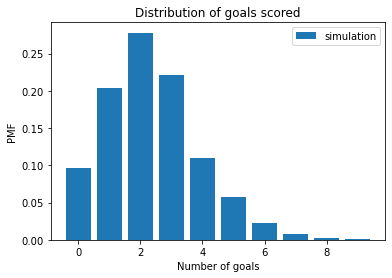

In [9]:
pmf_sim.bar(label='simulation')
decorate_goals()

plt.savefig('zigzag1.png', dpi=150)

## Poisson process

For large values of `n`, the process we just simulated converges to the Poisson distribution with parameter `mu = n * p`, which is also `mu = lam_per_game`.

We can use NumPy to generate a sample from a Poisson distribution.

In [10]:
n = 60
p = lam_per_min
mu = n * p
sample_poisson = np.random.poisson(mu, size)
np.mean(sample_poisson)

2.405

And confirm that the results are similar to what we got from the model.

In [11]:
pmf_poisson = Pmf.from_seq(sample_poisson)

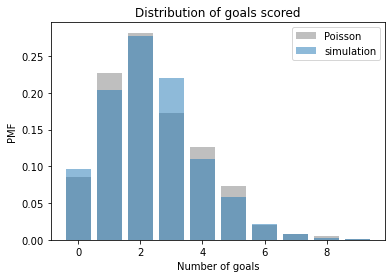

In [12]:
pmf_poisson.bar(color='gray', label='Poisson', alpha=0.5)
pmf_sim.bar(label='simulation', alpha=0.5)
decorate_goals()

plt.savefig('zigzag2.png', dpi=150)

But plotting PMFs is a bad way to compare distributions.  It's better to use the cumulative distribution function (CDF).

In [13]:
from empiricaldist import Cdf

def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    Cdf.from_seq(sample).plot(**options)

Comparing CDFs makes it clearer that the results from the simulation are consistent with the Poisson model.

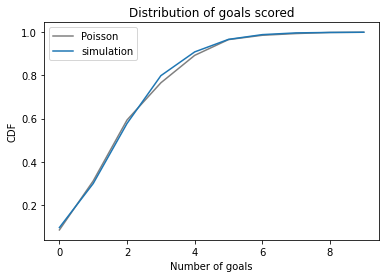

In [14]:
pmf_poisson.make_cdf().plot(color='gray', label='Poisson')
plot_cdf(sample_sim, label='simulation')
decorate_goals('CDF')

plt.savefig('zigzag3.png', dpi=150)

## Warming up PyMC

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [15]:
model = pm.Model()

with model:
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

In [16]:
len(trace['goals'])

1000

In [17]:
sample_pymc = trace['goals']
np.mean(sample_pymc)

2.389

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

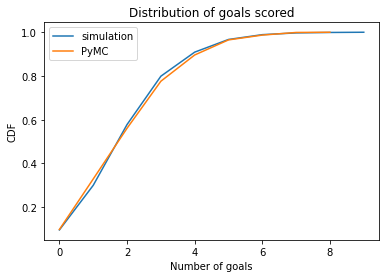

In [18]:
plot_cdf(sample_sim, label='simulation')
plot_cdf(sample_pymc, label='PyMC')
decorate_goals('CDF')

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its PMF analytically, and SciPy provides an implementation.

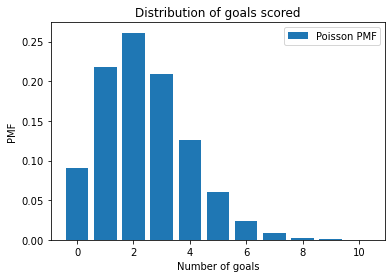

In [19]:
from scipy.stats import poisson

xs = np.arange(11)
mu = 2.4

ps = poisson.pmf(xs, mu)
plt.bar(xs, ps, label='Poisson PMF')
decorate_goals()

Here's the probability of scoring 4 goals in a game if the long-term rate is 2.4 goals per game.

In [20]:
data = 4
poisson.pmf(data, mu)

0.1254084986272838

In [21]:
mus = np.linspace(0, 15, num=101)
likelihood = poisson.pmf(4, mus)
likelihood

array([0.00000000e+00, 1.81555589e-05, 2.50026149e-04, 1.08944747e-03,
       2.96358283e-03, 6.22748873e-03, 1.11145981e-02, 1.77229800e-02,
       2.60231799e-02, 3.58778394e-02, 4.70665182e-02, 5.93114635e-02,
       7.23017337e-02, 8.57142371e-02, 9.92310359e-02, 1.12552785e-01,
       1.25408499e-01, 1.37562022e-01, 1.48815687e-01, 1.59011643e-01,
       1.68031356e-01, 1.75793720e-01, 1.82252178e-01, 1.87391193e-01,
       1.91222339e-01, 1.93780255e-01, 1.95118616e-01, 1.95306276e-01,
       1.94423652e-01, 1.92559429e-01, 1.89807621e-01, 1.86264988e-01,
       1.82028837e-01, 1.77195165e-01, 1.71857150e-01, 1.66103943e-01,
       1.60019753e-01, 1.53683172e-01, 1.47166728e-01, 1.40536620e-01,
       1.33852618e-01, 1.27168093e-01, 1.20530156e-01, 1.13979883e-01,
       1.07552602e-01, 1.01278229e-01, 9.51816428e-02, 8.92830728e-02,
       8.35984979e-02, 7.81400478e-02, 7.29163965e-02, 6.79331437e-02,
       6.31931800e-02, 5.86970320e-02, 5.44431858e-02, 5.04283870e-02,
      

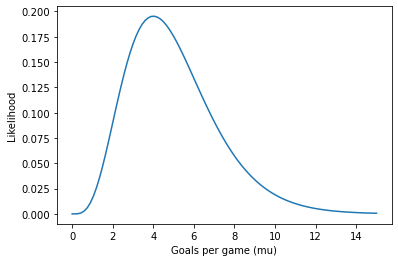

In [22]:
plt.plot(mus, likelihood)
plt.xlabel('Goals per game (mu)')
plt.ylabel('Likelihood');

## Bayesian inference with grid approximation

Ok, it's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

I'll start with a uniform prior just to keep things simple.  We'll choose a better prior later.

In [23]:
uniform_prior = Pmf(1, mus)
uniform_prior.normalize()

101

Initially `uniform_prior` represents the prior distribution of `mu`.

In [24]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

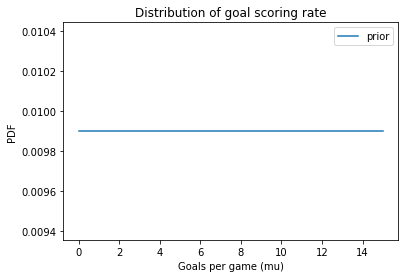

In [25]:
uniform_prior.plot(label='prior')
decorate_rate()

plt.savefig('zigzag4.png', dpi=150)

Now we can update it with the data and plot the posterior.

In [26]:
data = 4
likelihood = poisson.pmf(data, mus)

In [27]:
posterior1 = uniform_prior * likelihood
posterior1.normalize()

0.06595319262654087

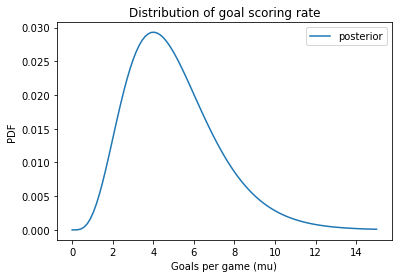

In [28]:
posterior1.plot(label='posterior')
decorate_rate()

plt.savefig('zigzag5.png', dpi=150)

With a uniform prior, the posterior is the likelihood function, and the MAP is the value of `mu` that maximizes likelihood, which is the observed number of goals, 4.

This result is probably not reasonable, because the prior was not reasonable.

## A better prior

To construct a better prior, I'll use a Gamma distribution with parameters chosen to be consistent with previous playoff games.

We can use `make_gamma_dist` to construct a prior suite with the given parameters.

In [29]:
from scipy.stats import gamma

def make_gamma_dist(xs, alpha, beta):
    """Makes a Pmf based on a gamma distribution.
    
    xs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: Suite
    """
    ps = gamma(a=alpha, scale=1/beta).pdf(xs)
    pmf = Pmf(ps, xs)
    pmf.normalize()
    return pmf

In [30]:
alpha = 2 * mu
beta = 2

alpha, beta

(4.8, 2)

In [31]:
mus = np.linspace(0, 10, num=101)
gamma_prior = make_gamma_dist(mus, alpha, beta)
gamma_prior.mean(), gamma_prior.std()

(2.3999058206863504, 1.0950953778534671)

Here's what it looks like.

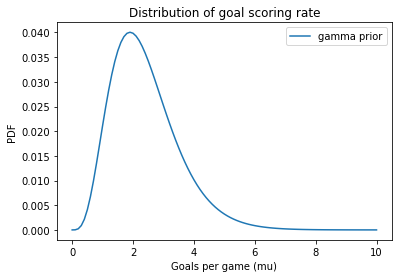

In [32]:
gamma_prior.plot(label='gamma prior')
decorate_rate()

plt.savefig('zigzag6.png', dpi=150)

And we can update this prior using the observed data.

In [33]:
data = 4
likelihood = poisson.pmf(data, mus)

In [34]:
posterior2 = gamma_prior * likelihood
posterior2.normalize()

0.10847827095097823

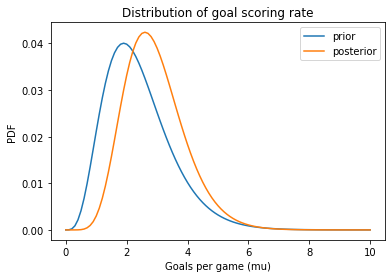

In [35]:
gamma_prior.plot(label='prior')
posterior2.plot(label='posterior')
decorate_rate()

plt.savefig('zigzag7.png', dpi=150)

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here are the parameters we used to create the gamma prior:

In [36]:
print(alpha, beta)

4.8 2


Here's what the PyMC model looks like:

In [37]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [38]:
sample_prior_pymc = trace['mu']
np.mean(sample_prior_pymc)

2.4049689094653752

And compare it to a sample from the gamma prior.

In [39]:
sample_prior_gamma = gamma_prior.sample(1000, replace=True)

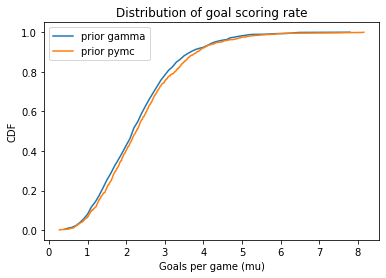

In [40]:
plot_cdf(sample_prior_gamma, label='prior gamma')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_rate('CDF')

plt.savefig('zigzag10.png', dpi=150)

It looks pretty good.

The distributions of `goals` from this model is the prior predictive.

In [41]:
sample_prior_pred_pymc = trace['goals']
np.mean(sample_prior_pred_pymc)

2.458

And let's compare it to a prior predictive distribution estimated by sampling.

In [42]:
sample_prior_pred = np.random.poisson(sample_prior_gamma)
np.mean(sample_prior_pred)

2.294

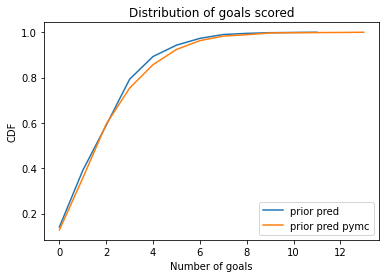

In [43]:
plot_cdf(sample_prior_pred, label='prior pred')
plot_cdf(sample_prior_pred_pymc, label='prior pred pymc')
decorate_goals('CDF')

plt.savefig('zigzag11.png', dpi=150)

Looks good.

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of called `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [44]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1811.97draws/s]
The acceptance probability does not match the target. It is 0.8987332936679537, but should be close to 0.8. Try to increase the number of tuning steps.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

In [45]:
len(trace['mu'])

1000

/home/downey/anaconda3/envs/BayesMadeSimple/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


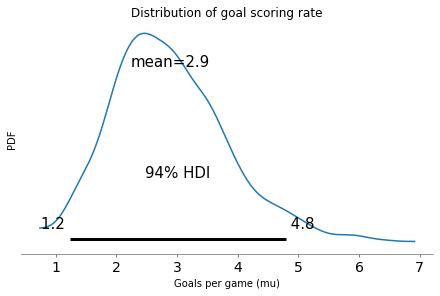

In [46]:
import arviz as az

az.plot_posterior(trace)
decorate_rate()

We can extract a sample of `mu` from the trace.

In [47]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

2.892443574486193

And compare it to the sample we drew from the grid approximation:

In [48]:
sample_post = posterior2.sample(1000, replace=True)
sample_post.mean()

2.9375

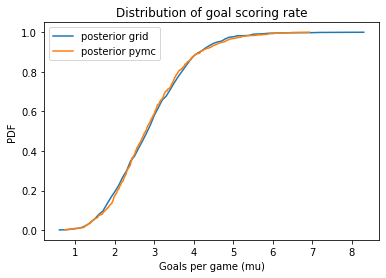

In [49]:
plot_cdf(sample_post, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior pymc')
decorate_rate()

plt.savefig('zigzag12.png', dpi=150)

Again, it looks pretty good.

## Posterior predictive

To sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [50]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2053.45it/s]


Here's what it looks like:

In [51]:
sample_post_pred_pymc = post_pred['goals']
np.mean(sample_post_pred_pymc)

2.888

In [52]:
sample_post_pred = poisson(sample_post).rvs()
sample_post_pred.mean()

2.991

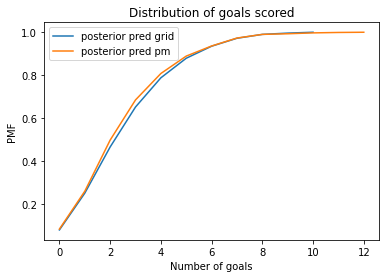

In [53]:
plot_cdf(sample_post_pred, label='posterior pred grid')
plot_cdf(sample_post_pred_pymc, label='posterior pred pm')
decorate_goals()

plt.savefig('zigzag13.png', dpi=150)

Looks pretty good!

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [54]:
model = pm.Model()

with model:
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_ANA = pm.Gamma('mu_ANA', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=3)
    goals_ANA = pm.Poisson('goals_ANA', mu_ANA, observed=2)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_ANA, mu_BOS]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1485.12draws/s]


We can use `traceplot` to review the results and do some visual diagnostics.

/home/downey/anaconda3/envs/BayesMadeSimple/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


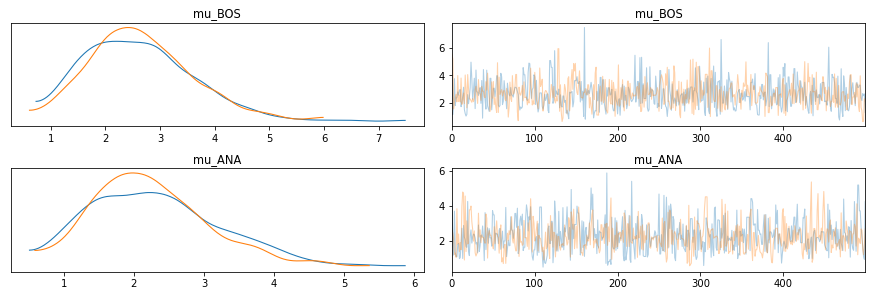

In [55]:
az.plot_trace(trace);

Here are the posterior distribitions for `mu_BOS` and `mu_ANA`.

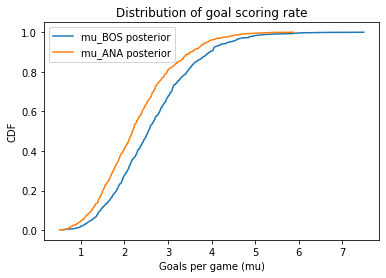

In [56]:
mu_BOS = trace['mu_BOS']
plot_cdf(mu_BOS, label='mu_BOS posterior')

mu_ANA = trace['mu_ANA']
plot_cdf(mu_ANA, label='mu_ANA posterior')

decorate_rate('CDF')
np.mean(mu_BOS), np.mean(mu_ANA)

plt.savefig('zigzag14.png', dpi=150)

On the basis of one game here's the probability that Boston is the better team.

In [57]:
np.mean(mu_BOS > mu_ANA)

0.613

In [58]:
np.mean(mu_BOS == mu_ANA)

0.0

## Predictions

Even if Boston is the better team, that doesn't mean they'll win the next game.

We can use `sample_posterior_predictive` to generate predictions.

In [59]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1004.47it/s]


Here are the posterior predictive distributions of goals scored.

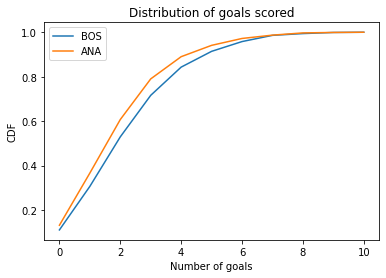

In [60]:
goals_BOS = post_pred['goals_BOS'].flatten()
goals_ANA = post_pred['goals_ANA'].flatten()

plot_cdf(goals_BOS, label='BOS')
plot_cdf(goals_ANA, label='ANA')
decorate_goals('CDF')

plt.savefig('zigzag15.png', dpi=150)

Here's the chance that Boston wins the next game.

In [61]:
win = np.mean(goals_BOS > goals_ANA)
win

0.479

The chance that they lose.

In [62]:
lose = np.mean(goals_ANA > goals_BOS)
lose

0.37

And the chance of a tie.

In [63]:
tie = np.mean(goals_BOS == goals_ANA)
tie

0.151

## Going hierarchical

So far, all of this is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

Here's a PyMC model that generates `alpha` and `beta` from an exponential distribution.

In [64]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    trace = pm.sample_prior_predictive(1000)

Here's what the distributions of `alpha` and `beta` look like.

1.0403259070913837

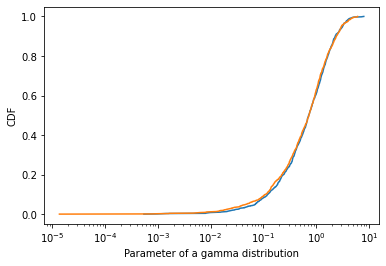

In [65]:
sample_prior_alpha = trace['alpha']
plot_cdf(sample_prior_alpha, label='alpha prior')
sample_prior_beta = trace['beta']
plot_cdf(sample_prior_beta, label='beta prior')

plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample_prior_alpha)

Now that we have `alpha` and `beta`, we can generate `mu`.

In [66]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

Here's what the prior distribution of `mu` looks like.

5.503592516172356

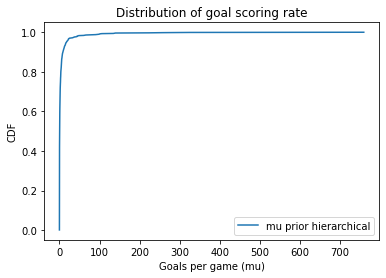

In [67]:
sample_prior_mu = trace['mu']
plot_cdf(sample_prior_mu, label='mu prior hierarchical')
decorate_rate('CDF')
np.mean(sample_prior_mu)

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."

If we zoom in on the range 0 to 10, we can compare the prior implied by the hierarchical model with the gamma prior I hand picked.

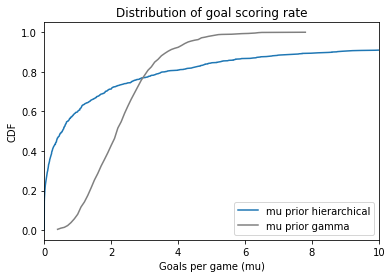

In [68]:
plot_cdf(sample_prior_mu, label='mu prior hierarchical')
plot_cdf(sample_prior_gamma, label='mu prior gamma', color='gray')
plt.xlim(0, 10)
decorate_rate('CDF')

Obviously, they are very different.  They agree that the most likely values are less than 10, but the hierarchical model admits the possibility that `mu` could be orders of magnitude bigger.

Strange as it sounds, that's probably what we want in a non-committal prior.

Ok, last step of the forward process, let's generate some goals.

In [69]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

Here's the prior predictive distribution of goals.

5.59

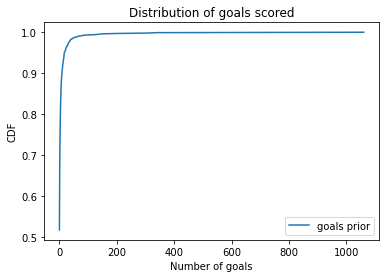

In [70]:
sample_prior_goals = trace['goals']
plot_cdf(sample_prior_goals, label='goals prior')
decorate_goals('CDF')
np.mean(sample_prior_goals)

To see whether that distribution is right, I ran samples using SciPy.

In [71]:
import scipy.stats as st

def forward_hierarchical(size=1):
    alpha = st.expon().rvs(size=size)
    beta = st.expon().rvs(size=size)
    mu = st.gamma(a=alpha, scale=1/beta).rvs(size=size)
    goals = st.poisson(mu).rvs(size=size)
    return goals[0]

sample_prior_goals_st = [forward_hierarchical() for i in range(1000)];

4.738

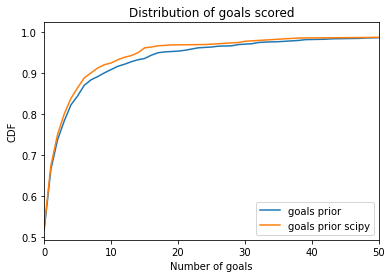

In [72]:
plot_cdf(sample_prior_goals, label='goals prior')
plot_cdf(sample_prior_goals_st, label='goals prior scipy')
decorate_goals('CDF')
plt.xlim(0, 50)
plt.legend(loc='lower right')
np.mean(sample_prior_goals_st)

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [73]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[3, 3])
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 906.01draws/s] 


Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

2.8394035354317455

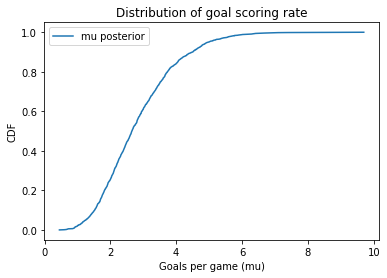

In [74]:
sample_post_mu = trace['mu']
plot_cdf(sample_post_mu, label='mu posterior')
decorate_rate('CDF')
np.mean(sample_post_mu)

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [75]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=[3, 3])
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[2, 3])
    trace = pm.sample(1000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_TBL, mu_BOS, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:05<00:00, 573.87draws/s]


/home/downey/anaconda3/envs/BayesMadeSimple/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


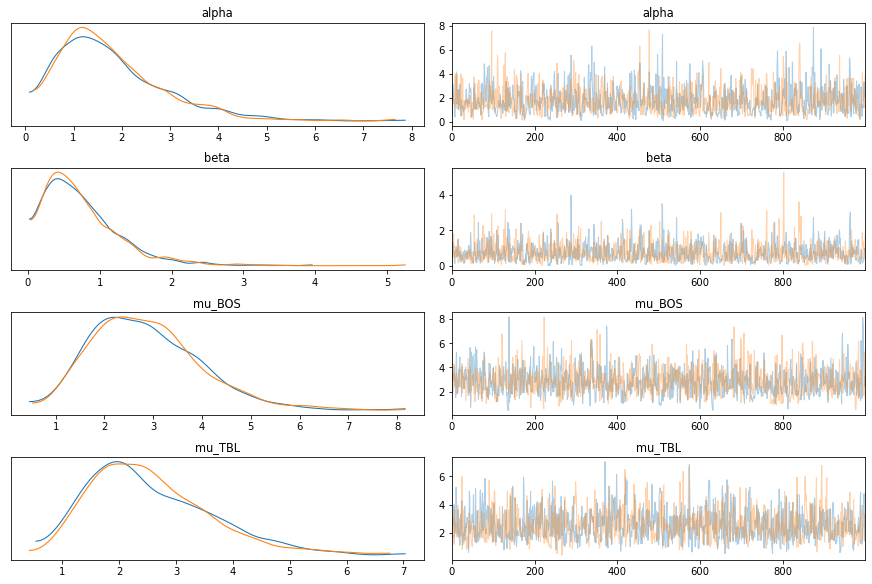

In [76]:
az.plot_trace(trace)
plt.show()

<AxesSubplot:title={'center':'x'}>

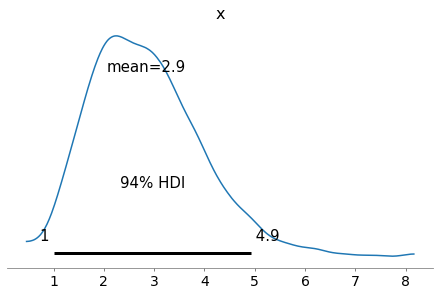

In [77]:
az.plot_posterior(trace['mu_BOS'])

<AxesSubplot:title={'center':'x'}>

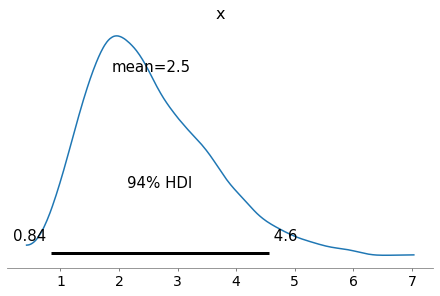

In [78]:
az.plot_posterior(trace['mu_TBL'])

Here are the posterior distribitions for `mu_TBL` and `mu_BOS`.

(2.5408811985074053, 2.851252727273467)

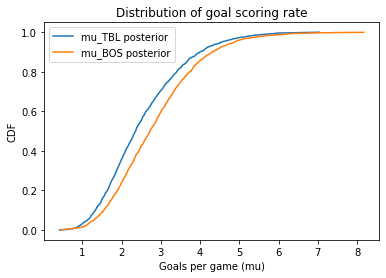

In [79]:
sample_post_mu_TBL = trace['mu_TBL']
plot_cdf(sample_post_mu_TBL, label='mu_TBL posterior')

sample_post_mu_BOS = trace['mu_BOS']
plot_cdf(sample_post_mu_BOS, label='mu_BOS posterior')

decorate_rate('CDF')
np.mean(sample_post_mu_TBL), np.mean(sample_post_mu_BOS)

On the basis of one game (and never having seen a previous game), here's the probability that Boston is the better team.

In [80]:
np.mean(sample_post_mu_BOS > sample_post_mu_TBL)

0.594

## More background

But let's take advantage of more information.  Here are the results from the seven most recent Stanley Cup finals, ignoring games that went into overtime.

In [81]:
data = dict(BOS13 = [2, 1, 2],
            CHI13 = [0, 3, 3],
            NYR14 = [0, 2],
            LAK14 = [3, 1],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 4, 1],
            PIT16 = [3, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            BOS19 = [2, 7, 2, 1, 5, 1],
            STL19 = [2, 2, 4, 2, 1, 4],
            BOS20 = [3, 2],
            TBL20 = [2, 3],
           )

Here's how we can get the data into the model.

In [82]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(1000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_TBL20, mu_BOS20, mu_STL19, mu_BOS19, mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:22<00:00, 133.98draws/s]


And here are the results.

/home/downey/anaconda3/envs/BayesMadeSimple/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


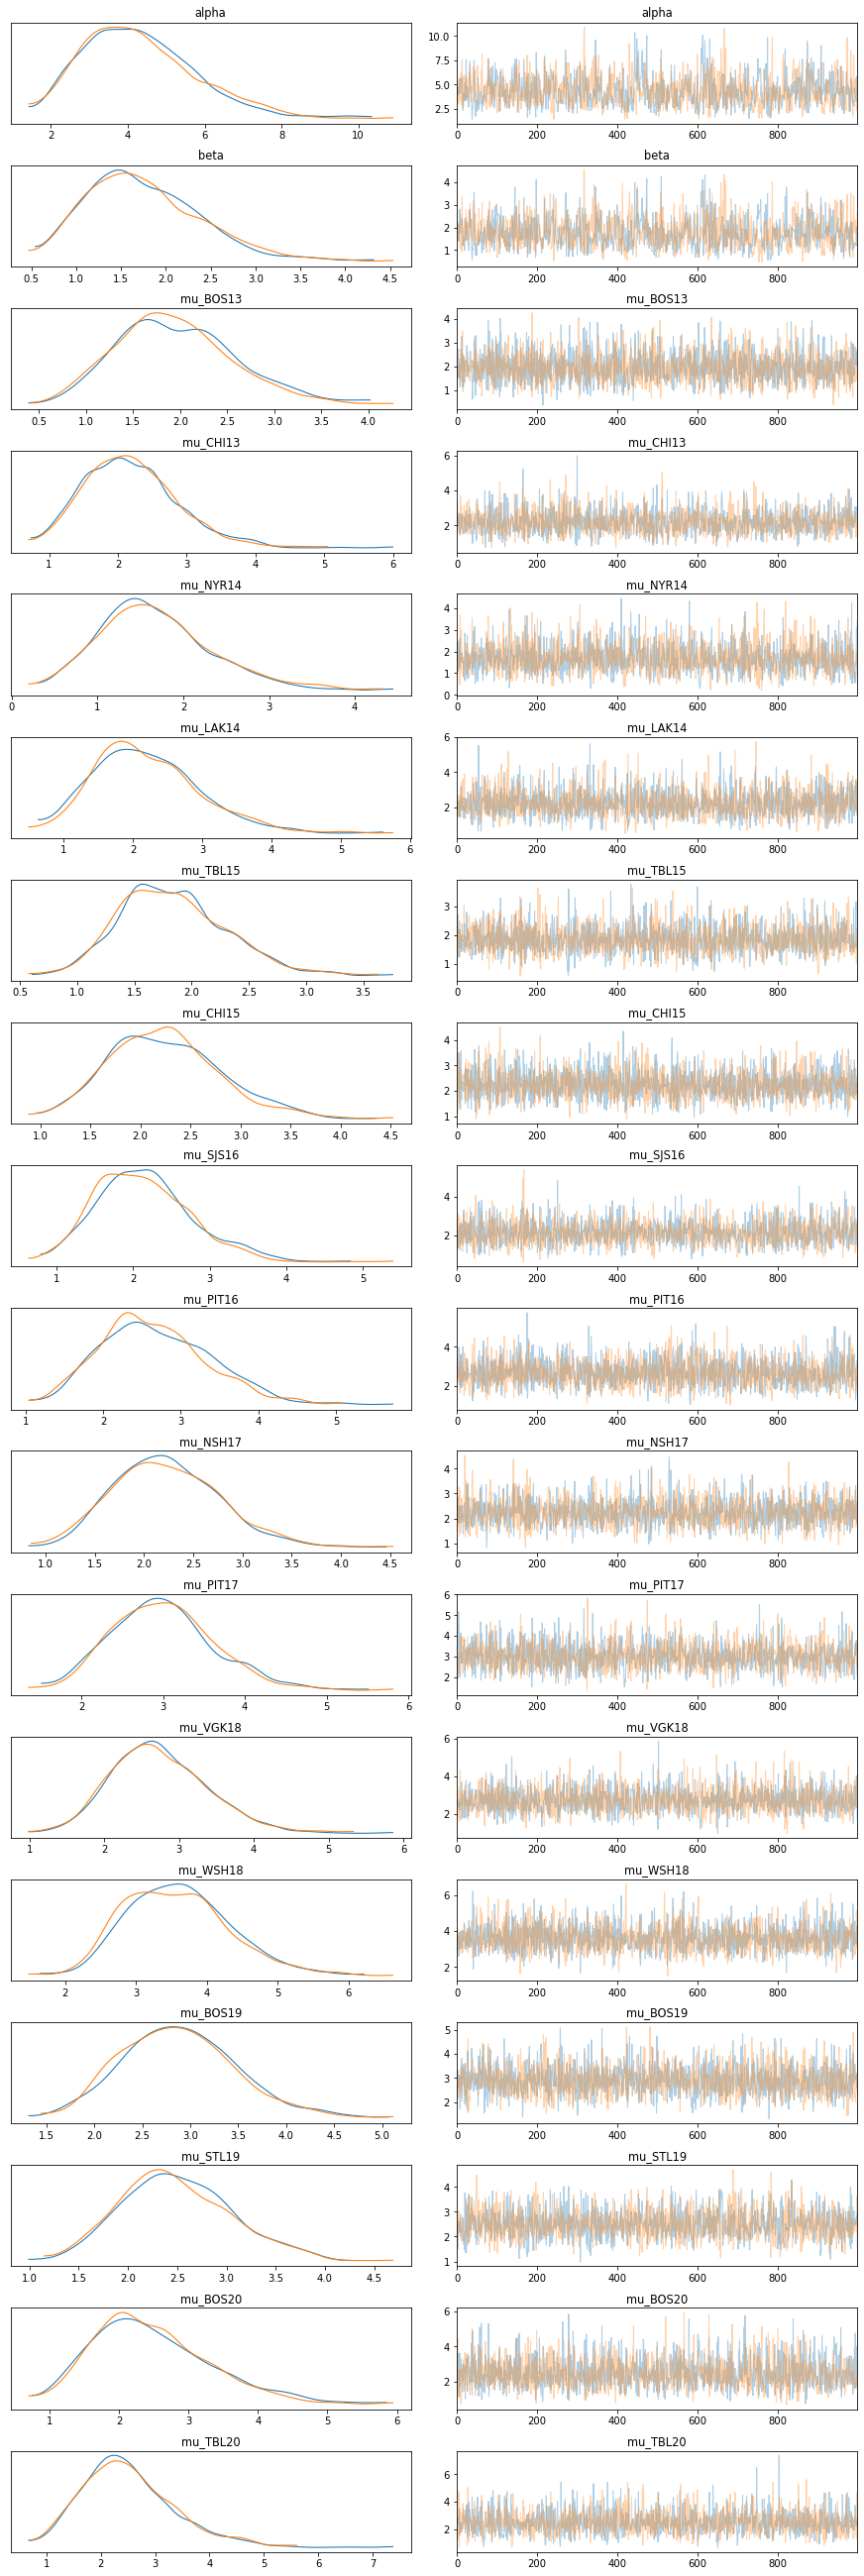

In [83]:
az.plot_trace(trace);

Here are the posterior means.

In [84]:
sample_post_mu_BOS = trace['mu_BOS20']
np.mean(sample_post_mu_BOS)

2.4764451892734787

In [85]:
sample_post_mu_TBL = trace['mu_TBL20']
np.mean(sample_post_mu_TBL)

2.50056190312807

They are lower with the background information than without, and closer together.  Here's the updated chance that Boston is the better team.

In [86]:
np.mean(sample_post_mu_BOS > sample_post_mu_TBL)

0.4895

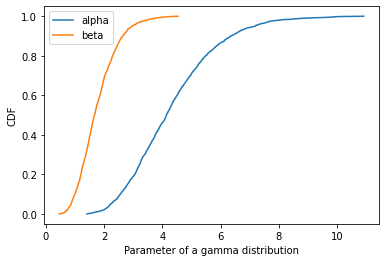

In [87]:
plot_cdf(trace['alpha'], label='alpha')
plot_cdf(trace['beta'], label='beta')

plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
plt.legend();

In [88]:
np.mean(trace['alpha'])

4.328040284490538

In [89]:
np.mean(trace['beta'])

1.7694119386054248

In [90]:
np.mean(trace['alpha'] / trace['beta'])

2.496267189052873

In [91]:
np.mean(trace['alpha'] / trace['beta']**2)

1.66620903087306